<a href="https://colab.research.google.com/github/plato2000/covid19-datascience-tutorial/blob/master/CMSC320_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMSC320 Final Project: Data Science with COVID-19 Data
## Parth Oza, Jagan Prem | CMSC320 | Spring 2020

## Introduction
In this tutorial, we will go through the entire data science pipeline in Python, from data curation/parsing/management, exploratory data analysis, hypothesis testing, and machine learning.

We will use COVID-19 testing data, as of 5/17/2020, in our analysis. We will look to answer the question, *did testing earlier help countries limit deaths due to COVID-19?* Answering this question is critically important to determine if countries could have done more to reduce deaths due to COVID-19. IF there is a correlation between later testing and higher deaths, the governments of countries which had delayed testing are partially to blame for their increased deaths.

Data science is crucial in many similar applications to this. While some might believe it to be obvious that earlier testing would result in fewer deaths, doing a statistical analysis, as we will do in this tutorial, is very important to scientifically prove a correlation rather than relying on what people believe to be obvious. After all, different people may consider different things to be obvious, so proving statements with statistics is crucial.

## Initial Setup

We will use some Python libraries to do our data analysis. Specifically, we will use `pandas` for data manipulation and analysis, `numpy` for math, `plotnine` for plotting (replicating R `ggplot`'s functionality), and `sklearn` for hypothesis testing.

In [0]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Data Curation, Parsing, and Management

The first step to any data science project is to figure out what data we're going to use. In this case, we were able to find a well-formatted and up to date dataset simply by Googling "covid 19 data csv". From here, we can get our link to the CSV and feed it to [`pandas`' `read_csv` function.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [4]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=[2])
df = df.dropna(subset=['total_cases', 'new_cases', 'total_tests', 'new_tests'])
df

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
595,ARG,Argentina,2020-04-09,1795,80,65,5,39.716,1.770,1.438,0.111,14850.0,1520.0,0.329,0.034,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
596,ARG,Argentina,2020-04-10,1894,99,79,14,41.907,2.190,1.748,0.310,16379.0,1529.0,0.362,0.034,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
597,ARG,Argentina,2020-04-11,1975,81,82,3,43.699,1.792,1.814,0.066,18027.0,1648.0,0.399,0.036,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
600,ARG,Argentina,2020-04-14,2272,69,98,3,50.270,1.527,2.168,0.066,22805.0,3047.0,0.505,0.067,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
601,ARG,Argentina,2020-04-15,2432,160,105,7,53.810,3.540,2.323,0.155,24374.0,1569.0,0.539,0.035,tests performed,45195777.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17633,ZWE,Zimbabwe,2020-05-09,35,1,4,0,2.355,0.067,0.269,0.000,9593.0,852.0,0.645,0.057,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
17634,ZWE,Zimbabwe,2020-05-10,36,1,4,0,2.422,0.067,0.269,0.000,9872.0,279.0,0.664,0.019,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
17635,ZWE,Zimbabwe,2020-05-11,36,0,4,0,2.422,0.000,0.269,0.000,10598.0,726.0,0.713,0.049,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7
17636,ZWE,Zimbabwe,2020-05-12,37,1,4,0,2.489,0.067,0.269,0.000,11058.0,460.0,0.744,0.031,tests performed,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7


The `read_csv` function is quite useful to be able to automatically convert a CSV file into a a `DataFrame`. Looking at the documentation linked above, we can see `read_csv` has many options it can take to make reading poorly formatted CSV files more easy. Fortunately, in this case, the data is already tidied for us and is easy to parse.

If the data had been in an [HTML table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html) or [Excel document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) or [JSON file](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html), `pandas` has functions to make reading those formats simple as well.

Looking at the `read_csv` function documentation, we can see that it has an optional parameter `parse_dates`. This allows us to automatically convert the date column in our dataset into a datetime object rather than a string. 

We know that we're planning on analyzing data from this dataset regarding testing and death rate. We also know that not all countries report their death rates and testing, but report some other metrics. As a result, our dataframe has some `NaN` values (meaning no data) for some countries' data in those columns. To make sure that this doesn't impact our data, we can run `df.dropna` on  the columns we care about, which will remove the rows that have a `NaN` value in those columns.


In [3]:
df.location.unique()

array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Belarus', 'Bolivia', 'Canada',
       'Switzerland', 'Chile', 'Colombia', 'Costa Rica', 'Cuba',
       'Czech Republic', 'Denmark', 'Estonia', 'Ethiopia', 'Finland',
       'France', 'United Kingdom', 'Ghana', 'Greece', 'Croatia',
       'Hungary', 'Indonesia', 'India', 'Iran', 'Iceland', 'Israel',
       'Italy', 'Kazakhstan', 'Kenya', 'South Korea', 'Lithuania',
       'Luxembourg', 'Latvia', 'Morocco', 'Mexico', 'Myanmar', 'Malaysia',
       'Nigeria', 'Netherlands', 'Norway', 'Nepal', 'New Zealand',
       'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Paraguay', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia',
       'Senegal', 'El Salvador', 'Serbia', 'Slovakia', 'Slovenia',
       'Tunisia', 'Turkey', 'Taiwan', 'Uganda', 'Ukraine', 'Uruguay',
       'United States', 'Vietnam', 'South Africa', 'Zimbabwe'],
      dtype=object)

In [4]:
len(df.location.unique())

74

We can see that after dropping the data that would leave our dataset incomplete, we have data from 74 countries remaining.

## Exploratory Data Analysis



/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


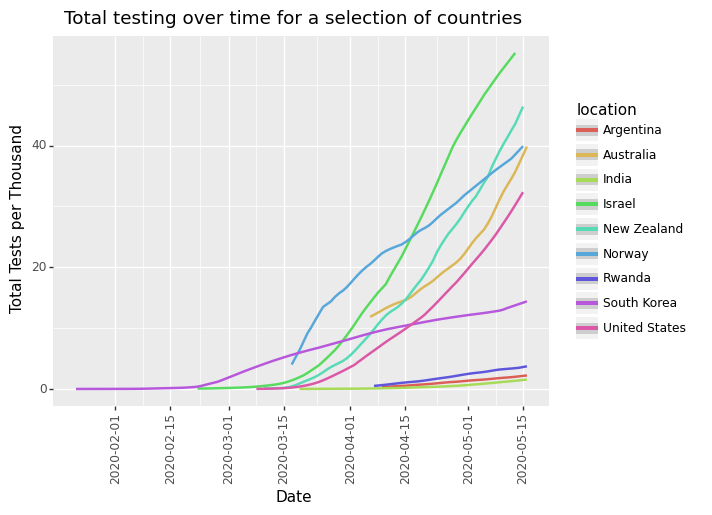

<ggplot: (-9223363285640060209)>

In [5]:
countries_to_analyze = ["United States", "South Korea", "Norway", "India", "Argentina", "Israel", "Rwanda", "New Zealand", "Australia"]

(ggplot(df.loc[df["location"].isin(countries_to_analyze)])
    + aes(x="date", y="total_tests_per_thousand", color="location")
    # + geom_point()
    + geom_smooth(span=0.1)
    + xlab("Date")
    + ylab("Total Tests per Thousand")
    + ggtitle("Total testing over time for a selection of countries")
    + theme(axis_text_x=element_text(angle=90, vjust=1)))

In [0]:
df["death_rate"] = df["total_deaths"] / df["total_cases"]

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 214 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


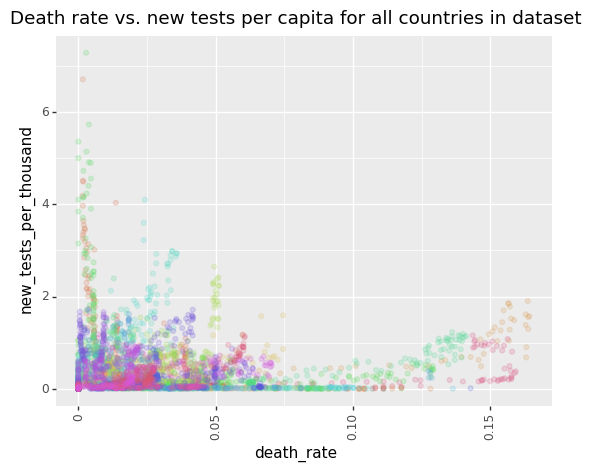

<ggplot: (-9223363285646351216)>

In [90]:

# (ggplot(df.loc[df["location"].isin(countries_to_analyze)])
(ggplot(df)
    + aes(x="death_rate", y="new_tests_per_thousand", color="location")
    + geom_point(alpha=0.2)
    # + geom_smooth(span=0.1)
    # + xlab("Date")
    # + ylab("Total Tests per Thousand")
    + ggtitle("Death rate vs. new tests per capita for all countries in dataset")
    + theme(axis_text_x=element_text(angle=90, vjust=1))
    + scale_color_discrete(guide=False))

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 94 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


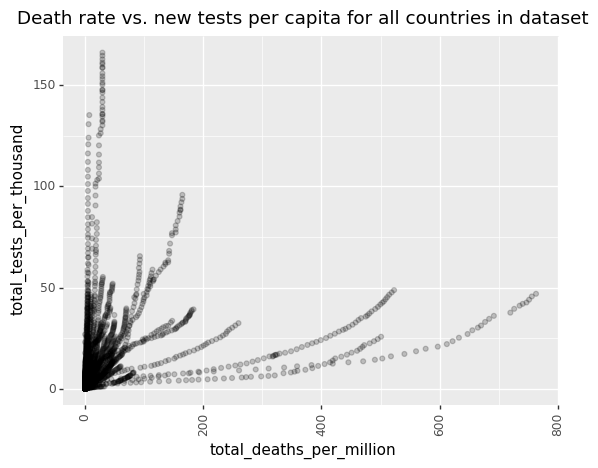

<ggplot: (8751204907773)>

In [111]:
agg_data = df[["total_tests_per_thousand", "total_deaths_per_million"]]#.groupby("location").agg({"total_tests_per_thousand": "max", "total_deaths_per_million": "max"})
(ggplot(agg_data)
    + aes(x="total_deaths_per_million", y="total_tests_per_thousand")
    + geom_point(alpha=0.2)
    # + geom_smooth(span=0.1)
    # + xlab("Date")
    # + ylab("Total Tests per Thousand")
    + ggtitle("Death rate vs. new tests per capita for all countries in dataset")
    + theme(axis_text_x=element_text(angle=90, vjust=1))
    + scale_color_discrete(guide=False))

In [109]:
scaler = StandardScaler()
data = df[["death_rate", "new_tests_per_thousand"]].dropna().values
scaler.fit(data)
k_means = KMeans(n_clusters=4).fit(scaler.transform(data))
df[["death_rate", "new_tests_per_thousand"]].dropna().values

array([[0.0362117 , 0.034     ],
       [0.04171067, 0.034     ],
       [0.04151899, 0.036     ],
       ...,
       [0.11111111, 0.049     ],
       [0.10810811, 0.031     ],
       [0.10810811, 0.009     ]])

In [0]:
new_scaler = StandardScaler()
new_data = agg_data.dropna().values
new_scaler.fit(new_data)
new_k_means = GaussianMixture(n_components=4).fit_predict(new_scaler.transform(new_data))

agg_clustered_data = agg_data.copy().dropna()
agg_clustered_data["cluster_label"] = new_k_means
agg_clustered_data["cluster_label"] = agg_clustered_data["cluster_label"].astype("category")


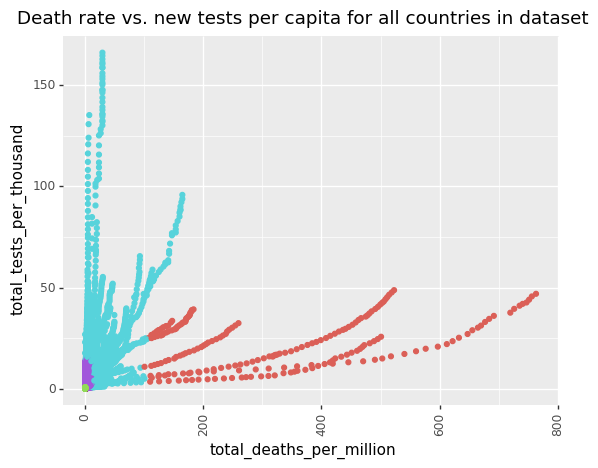

<ggplot: (-9223363285646956821)>

In [117]:
(ggplot(agg_clustered_data)
    + aes(x="total_deaths_per_million", y="total_tests_per_thousand", color="cluster_label")
    + geom_point()
    # + geom_smooth(span=0.1)
    # + xlab("Date")
    # + ylab("Total Tests per Thousand")
    + ggtitle("Death rate vs. new tests per capita for all countries in dataset")
    + theme(axis_text_x=element_text(angle=90, vjust=1))
    + scale_color_discrete(guide=False))

In [0]:
clustered_data = df.copy().dropna(subset=["death_rate", "new_tests_per_thousand"])
clustered_data["cluster_label"] = k_means.labels_
clustered_data["cluster_label"] = clustered_data["cluster_label"].astype("category")

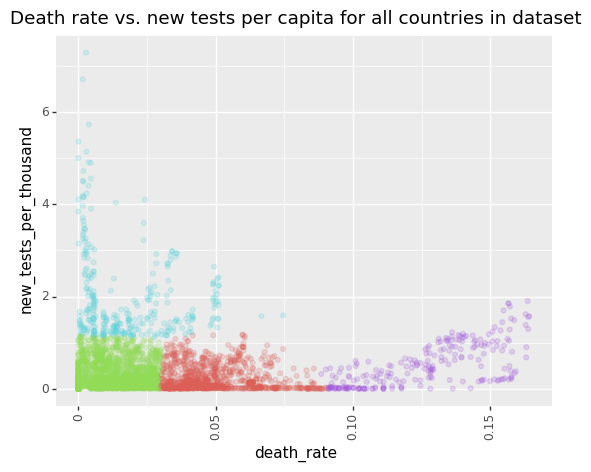

<ggplot: (-9223363285646637340)>

In [83]:
(ggplot(clustered_data)
    + aes(x="death_rate", y="new_tests_per_thousand", color="cluster_label")
    + geom_point(alpha=0.2)
    # + geom_smooth(span=0.1)
    # + xlab("Date")
    # + ylab("Total Tests per Thousand")
    + ggtitle("Death rate vs. new tests per capita for all countries in dataset")
    + theme(axis_text_x=element_text(angle=90, vjust=1))
    + scale_color_discrete(guide=False))

In [87]:
clustered_data.groupby("cluster_label").agg({"extreme_poverty": "mean"})

,extreme_poverty
cluster_label,
0,5.068165
1,6.400221
2,0.381624
3,2.984279


In [88]:
clustered_data.groupby("cluster_label").agg({"extreme_poverty": "std"})

,extreme_poverty
cluster_label,
0,8.190357
1,12.640819
2,0.290412
3,5.080891


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 94 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


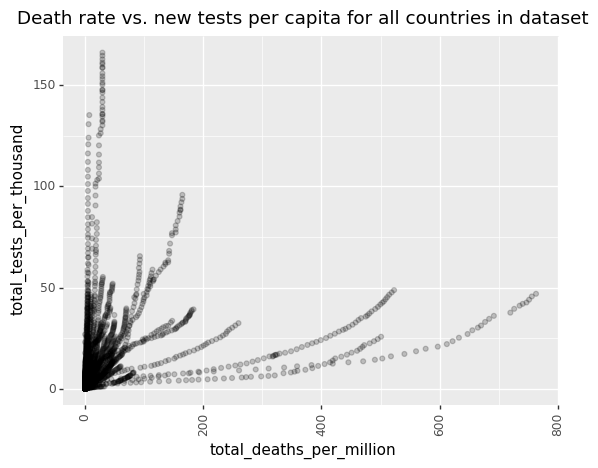

<ggplot: (8751204907773)>

In [0]:
agg_data = df[["total_tests_per_thousand", "total_deaths_per_million"]]#.groupby("location").agg({"total_tests_per_thousand": "max", "total_deaths_per_million": "max"})
